In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# 初始化 WordNet 詞形還原器與停用詞
lm = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
# 讀取 IMDB 電影評論資料集，並隨機取樣 8500 筆樣本
df = pd.read_csv(r"/content/drive/MyDrive/Dataset/IMDB_Dataset.csv")
df = df.sample(8500, random_state=36)

In [ ]:
# 移除缺失值
df.isnull()
df = df.dropna()

In [ ]:
# 文本預處理函數，將評論轉換為小寫、去除標點符號、標記化、詞形還原等操作
def transform_data(review):
    # 使用BeautifulSoup移除HTML標記
    review = BeautifulSoup(review, "html.parser").get_text()
    # 將文本轉換為小寫
    review = review.lower()
    # 移除非字母字符
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    # 將文本分詞
    tokens = nltk.word_tokenize(review)
    # 進行詞形還原並移除停用詞
    review = [lm.lemmatize(token) for token in tokens if token not in stop_words]
    # 將處理後的單詞組合成一個文本字串
    review = " ".join(review)
    return review

In [ ]:
# 將文本資料進行預處理
tranformed_rev = df.review.apply(transform_data)

<ipython-input-7-482c5db4f95b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, "html.parser").get_text()


In [ ]:
# 切分訓練集和測試集
X = tranformed_rev
y = df.sentiment.replace({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
import numpy as np

# 使用 numpy 的 unique 函數來獲取每個類別的數量及其對應的標籤
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

# 轉換為字典格式方便查看
train_distribution = dict(zip(unique_train, counts_train))
test_distribution = dict(zip(unique_test, counts_test))

print('y_train 分布:', train_distribution)
print('y_test 分布:', test_distribution)


y_train 分布: {0: 3387, 1: 3413}
y_test 分布: {0: 847, 1: 853}


In [ ]:
# 特徵提取
tf = TfidfVectorizer()
cv = CountVectorizer()
# lb = LabelEncoder()
X_train = tf.fit_transform(X_train).toarray()
X_test = tf.transform(X_test).toarray()

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()

param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=2, scoring='accuracy', verbose=3)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
[CV 1/2] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.798 total time=  42.2s
[CV 2/2] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.801 total time=  26.6s
[CV 1/2] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.821 total time= 1.0min
[CV 2/2] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.821 total time=  54.2s
[CV 1/2] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.829 total time= 1.7min
[CV 2/2] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.827 total time= 1.7min
[CV 1/2] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.810 total time=  27.2s
[CV 2/2] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.818 t

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

In [ ]:
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

In [ ]:
best_rf_model = RandomForestClassifier(max_depth= None, min_samples_leaf=4, min_samples_split=5, n_estimators=200)
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200)

In [ ]:
# 定義繪製混淆矩陣和分類報告的函數
def plot_evaluation_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.show()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import accuracy_score

# 使用已經擬合好的模型進行預測
y_pred = best_rf_model.predict(X_test)

# 計算模型的正確率
accuracy = accuracy_score(y_test, y_pred)

print(f'Model Accuracy: {accuracy:.4f}')


Model Accuracy: 0.8518


Evaluating Model (GridSearchCV):


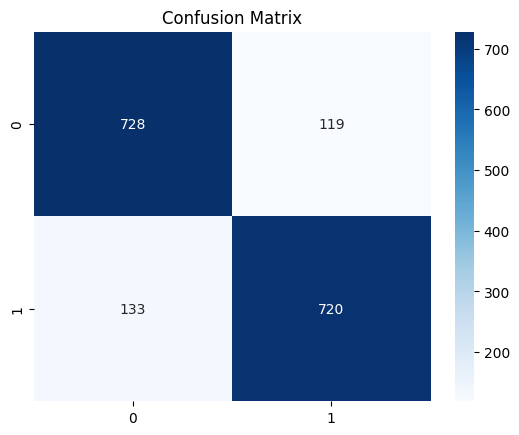

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       847
           1       0.86      0.84      0.85       853

    accuracy                           0.85      1700
   macro avg       0.85      0.85      0.85      1700
weighted avg       0.85      0.85      0.85      1700



In [ ]:
print(f"Evaluating Model (GridSearchCV):")
plot_evaluation_metrics(best_rf_model, X_test, y_test)